In [1]:
# pip install git+https://github.com/crispitagorico/sigkernel.git

### If parameter to vary is depth, generate Brownian motion outside loop (otherwise different sets of paths are generated for different parameter values, so the test is not fair). For all other parameters, the BM paths must be regenerated for each value of that parameter. But what about the time increment parameter?

## Untruncated signature kernel (Goursat PDE)
#### (a) $\phi \equiv 1$
#### (b) $\phi(k) = \mathbb{E}[\pi^k]$ where $\pi$ is a random variable

#### Check code below is doing centering correctly
#### Dyadic order is another parameter that can be varied

## Projection onto principal components (note: here we look at the covariance matrix of transformed features, but kernel PCA is supposed to use another covariance matrix)

In [9]:
# from tensorflow import keras
# from keras_sig import jax_gpu_signature



[Depth = 4]
  Standard PCA explained variance ratios:          [0.2968, 0.5628, 0.815, 0.8464, 0.8769, 0.9051, 0.9155, 0.9257, 0.9351, 0.9409, 0.9462, 0.9513, 0.9546, 0.9579, 0.9611, 0.9636, 0.9657, 0.9677, 0.9694, 0.971, 0.9725, 0.9737, 0.9749, 0.976, 0.977, 0.9779, 0.9788, 0.9795, 0.9802, 0.9809]
  Signature PCA explained variance ratios:         [0.0764, 0.1408, 0.1936, 0.2428, 0.2892, 0.3295, 0.3673, 0.4013, 0.433, 0.4595, 0.4828, 0.5031, 0.5225, 0.5416, 0.5596, 0.5766, 0.5927, 0.6076, 0.6222, 0.6362, 0.6489, 0.6612, 0.673, 0.6847, 0.6961, 0.7068, 0.7173, 0.7271, 0.7368, 0.7462]
  Signature+Time PCA explained variance ratios:    [0.1996, 0.3803, 0.548, 0.6582, 0.76, 0.8528, 0.8883, 0.9232, 0.954, 0.9596, 0.9642, 0.9688, 0.9712, 0.9733, 0.9753, 0.9771, 0.9789, 0.9806, 0.9821, 0.9836, 0.985, 0.9859, 0.9867, 0.9875, 0.9883, 0.989, 0.9897, 0.9904, 0.9911, 0.9918]
  Logsignature PCA explained variance ratios:      [0.2234, 0.3936, 0.504, 0.5724, 0.6293, 0.6796, 0.7222, 0.7613, 0.7955, 

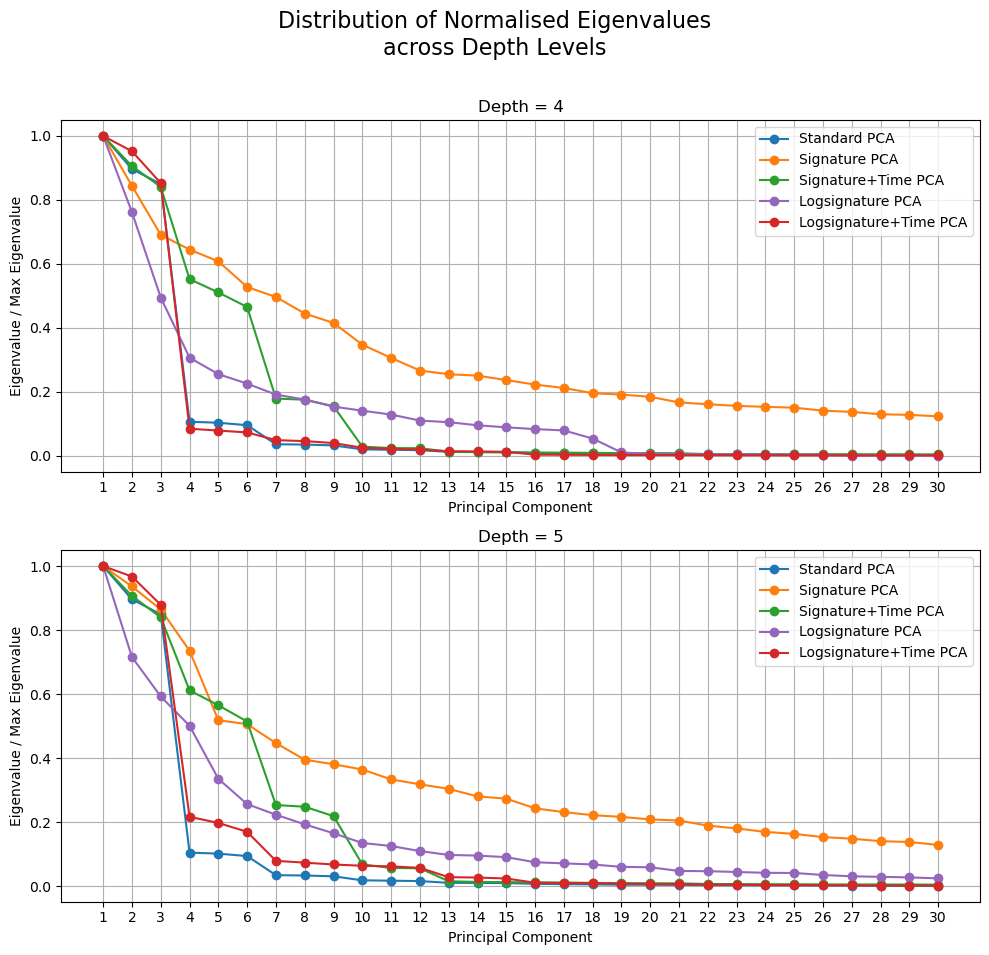

In [1]:
import iisignature
import numpy as np
import torch
import matplotlib.pyplot as plt

# Default parameters
num_samples    = 1000
len_x_default  = 300  # number of points in each path
len_x          = len_x_default
drift_default  = 0
drift          = drift_default
volatility_default = 1
volatility     = volatility_default
time_increment_default = 1
time_increment = time_increment_default
depth_default  = 5  # signature truncation level
depth          = depth_default
d_default      = 3  # path dimension
d              = d_default
num_pcs_default = 30   # number of principal components to keep
num_pcs        = num_pcs_default

# Parameter lists (for exploring how PCA‐eigenvalue spectra change)
path_dimension_list = [3, 4, 5]
depth_list          = [4, 5]  
drift_list          = [0.01, 0.1, 1, 10]
volatility_list     = [0.001, 0.01, 0.1, 1, 10]
time_increment_list = [0.001, 0.01, 0.1, 1, 10]
path_length_list    = [100, 300, 1000]

parameter_to_vary = 'depth'

if parameter_to_vary == 'depth':
    parameter_list = depth_list
elif parameter_to_vary == 'drift':
    parameter_list = drift_list
elif parameter_to_vary == 'volatility':
    parameter_list = volatility_list
elif parameter_to_vary == 'time increment':
    parameter_list = time_increment_list
elif parameter_to_vary == 'path length':
    parameter_list = path_length_list
elif parameter_to_vary == 'path dimension':
    parameter_list = path_dimension_list
else:
    raise ValueError("Unknown parameter_to_vary.")


# ----------------------------------------------------------------------------
# 1) Generate a batch of Brownian-motion–type paths (spatial only)
# ----------------------------------------------------------------------------
def generate_brownian_motion(num_samples, len_x, drift, volatility,
                             initial_condition=None, time_increment=0.1):
    """
    Returns a torch.Tensor of shape (num_samples, len_x, d):
      X[*, 0, :] = 0  (if initial_condition is zero)
      X[*, t, :] = cumulative sum of (dW + drift*Δt) up to index t.
    We do NOT append time here; this is purely spatial.
    """
    t_x = torch.linspace(0, (len_x - 1) * time_increment, len_x,
                         dtype=torch.float64).view(1, len_x, 1)  # (1, len_x, 1)
    dW = torch.randn(num_samples, len_x - 1, d, dtype=torch.float64) \
         * torch.sqrt(torch.tensor(time_increment, dtype=torch.float64)) \
         * volatility
    dW = torch.cat([
        torch.zeros(num_samples, 1, d, dtype=torch.float64),
        dW
    ], dim=1)  # (num_samples, len_x, d)
    X = torch.cumsum(dW, dim=1) + drift * t_x
    if initial_condition is not None:
        X = X + initial_condition.view(1, 1, d)
    return X  # (num_samples, len_x+1, d)


# ----------------------------------------------------------------------------
# 2) PCA helper (returns reconstruction too)
# ----------------------------------------------------------------------------
def perform_pca(X: np.ndarray, n_components: int):
    """
    Input:
      X: (n_samples, n_features)
    Returns:
      eigenvalues:        (n_features,) sorted descending
      projections:       (n_samples, k)         # principal‐component coefficients
      X_reconstructed:   (n_samples, n_features) # back‐projection into original basis
    """
    mean_X = np.mean(X, axis=0, keepdims=True)         # (1, n_features)
    X_centered = X - mean_X                             # (n_samples, n_features)
    cov = np.cov(X_centered, rowvar=False)              # (n_features, n_features)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    idx_desc = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx_desc]
    eigenvectors = eigenvectors[:, idx_desc]             # columns are sorted eigenvectors
    n_features = eigenvalues.shape[0]
    k = min(n_components, n_features)
    W = eigenvectors[:, :k]                              # (n_features, k)
    projections = X_centered @ W                          # (n_samples, k)
    X_reconstructed = projections @ W.T + mean_X          # (n_samples, n_features)
    return eigenvalues, projections, X_reconstructed


def cumulative_explained_variance(eigenvalues: np.ndarray, k):
    total_var = np.sum(eigenvalues)
    explained = np.cumsum(eigenvalues[:k])
    return [round(float(ev) / total_var, 4) for ev in explained]


# ----------------------------------------------------------------------------
# 3) Augmentation routines 
# ----------------------------------------------------------------------------
# If you need any other augmentation, add it explicitly, but here we compute
# signatures directly on the paths as given.

def add_time_to_paths(paths_spatial: np.ndarray, time_increment: float) -> np.ndarray:
    """
    Append a time channel to each path.
    Input:
      paths_spatial: (batch, len_x, d)
      time_increment: float
    Returns:
      paths_time: (batch, len_x, d+1) where paths_time[..., 0] is time,
                  and the remaining channels are the original spatial coords.
      Time starts at 0 for the first point, then time_increment, 2*time_increment, ..., (len_x-1)*time_increment.
    """
    batch, len_x, d_ = paths_spatial.shape
    # times: shape (len_x,), from 0 to (len_x-1)*time_increment
    times = np.arange(len_x, dtype=np.float64).reshape(1, len_x, 1) * time_increment
    times = np.tile(times, (batch, 1, 1))  # (batch, len_x, 1)
    return np.concatenate([times, paths_spatial], axis=2)  # (batch, len_x, d+1)


# ----------------------------------------------------------------------------
# 4) Batch signature / logsignature routines 
# ----------------------------------------------------------------------------
def batch_signature(paths_spatial: np.ndarray, depth: int) -> np.ndarray:
    """
    Compute signature directly on spatial-only paths.
    Input:
      paths_spatial: (batch, len_x, d)
    Returns:
      np.ndarray of shape (batch, sig_dim).
    """
    sigs = []
    for path in paths_spatial:
        # path: shape (len_x, d)
        sig = iisignature.sig(np.ascontiguousarray(path, dtype=np.float64), depth)
        sigs.append(sig)
    return np.array(sigs)  # (batch, sig_dim)


def batch_logsignature(paths_spatial: np.ndarray, depth: int) -> np.ndarray:
    """
    Compute logsignature directly on spatial-only paths.
    """
    # prepare state once per batch
    d_ = paths_spatial.shape[2]
    state = iisignature.prepare(d_, depth)
    logsigs = []
    for path in paths_spatial:
        logsig = iisignature.logsig(np.ascontiguousarray(path, dtype=np.float64), state)
        logsigs.append(logsig)
    return np.array(logsigs)  # (batch, logsig_dim)


def batch_signature_time(paths_spatial: np.ndarray,
                         depth: int,
                         time_increment: float) -> np.ndarray:
    """
    Compute signature on paths with an appended time channel.
    Input:
      paths_spatial: (batch, len_x, d)
      Returns: (batch, sig_dim) where sig_dim corresponds to channel dimension = d+1
    """
    # First append time channel
    paths_time = add_time_to_paths(paths_spatial, time_increment)  # (batch, len_x, d+1)
    sigs_time = []
    for path in paths_time:
        sig_t = iisignature.sig(np.ascontiguousarray(path, dtype=np.float64), depth)
        sigs_time.append(sig_t)
    return np.array(sigs_time)  # (batch, sig_dim)


def batch_logsignature_time(paths_spatial: np.ndarray,
                            depth: int,
                            time_increment: float) -> np.ndarray:
    """
    Compute logsignature on paths with an appended time channel.
    """
    paths_time = add_time_to_paths(paths_spatial, time_increment)  # (batch, len_x, d+1)
    # prepare state once: channel = d+1
    d_plus = paths_time.shape[2]
    state = iisignature.prepare(d_plus, depth)
    logsigs_time = []
    for path in paths_time:
        logsig_t = iisignature.logsig(np.ascontiguousarray(path, dtype=np.float64), state)
        logsigs_time.append(logsig_t)
    return np.array(logsigs_time)  # (batch, logsig_dim)


# ----------------------------------------------------------------------------
# ───── MAIN LOOP ─────
# ----------------------------------------------------------------------------

# 1) If varying “depth,” build X_fixed one time here; otherwise will generate inside the loop.
if parameter_to_vary == 'depth':
    initial_condition = torch.zeros(d, dtype=torch.float64)
    X_fixed = generate_brownian_motion(
        num_samples, len_x,
        drift=drift,
        volatility=volatility,
        initial_condition=initial_condition,
        time_increment=time_increment
    )  # (num_samples, len_x, d)

m = len(parameter_list)
fig, axs = plt.subplots(m, 1, figsize=(10, 5 * m))
colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red']

# Dictionaries to store every batch of paths and every reconstruction
X_dict = {}            # X_dict[param_val] = torch.Tensor of shape (1000, len_x, d)
X_np_dict = {}         # X_np_dict[param_val] = NumPy array (1000, len_x, d)
projections_dict = {}  # projections_dict[param_val][method] = (1000, k_method)
reconstructions_dict = {}  # reconstructions_dict[param_val][method] = (1000, n_features_method)

for i, parameter_value in enumerate(parameter_list):
    # 2) Update whichever parameter we’re varying
    if parameter_to_vary == 'depth':
        depth = parameter_value
    elif parameter_to_vary == 'drift':
        drift = parameter_value
    elif parameter_to_vary == 'volatility':
        volatility = parameter_value
    elif parameter_to_vary == 'time increment':
        time_increment = parameter_value
    elif parameter_to_vary == 'path length':
        len_x = parameter_value
    elif parameter_to_vary == 'path dimension':
        d = parameter_value

    # 3) Generate X for this iteration
    if parameter_to_vary == 'depth':
        # Reuse X_fixed whenever we vary depth 
        X = X_fixed.clone()
    else:
        # Regenerate a fresh batch because len_x, drift, etc. may have changed
        initial_condition = torch.zeros(d, dtype=torch.float64)
        X = generate_brownian_motion(
            num_samples, len_x,
            drift=drift,
            volatility=volatility,
            initial_condition=initial_condition,
            time_increment=time_increment
        )

    # 4) Store this iteration’s paths
    X_dict[parameter_value] = X.clone()
    X_np = X.numpy()
    X_np_dict[parameter_value] = X_np.copy()

    # 5) Prepare feature spaces
    X_flat_for_param    = X_np.reshape(num_samples, -1)                # shape (num_samples, len_x*d)
    sig_for_param       = batch_signature(X_np, depth)                 # shape (num_samples, n_sig)
    sig_time_for_param  = batch_signature_time(X_np, depth, time_increment)  # (num_samples, n_sig_time)
    logsig_for_param    = batch_logsignature(X_np, depth)              # (num_samples, n_logsig)
    logsig_time_for_param = batch_logsignature_time(X_np, depth, time_increment) # (num_samples, n_logsig_time)

    # 6) Create entries in both dicts
    projections_dict[parameter_value]     = {}
    reconstructions_dict[parameter_value] = {}

    # ────────────── STORE RECONSTRUCTIONS ──────────────

    # (a) Standard PCA on flattened paths:
    eigen_flat, proj_flat, recon_flat = perform_pca(X_flat_for_param, num_pcs)
    projections_dict[parameter_value]["standard"] = proj_flat          # shape = (num_samples, k_std)
    reconstructions_dict[parameter_value]["standard"] = recon_flat    # shape = (num_samples, len_x*d)

    # (b) Signature PCA:
    eigen_sig, proj_sig, recon_sig = perform_pca(sig_for_param, num_pcs)
    projections_dict[parameter_value]["signature"] = proj_sig         # (num_samples, k_sig)
    reconstructions_dict[parameter_value]["signature"] = recon_sig    # (num_samples, n_sig)

    # (c) Signature+Time PCA:
    eigen_sig_time, proj_sig_time, recon_sig_time = perform_pca(sig_time_for_param, num_pcs)
    projections_dict[parameter_value]["signature+time"] = proj_sig_time    # (num_samples, k_sig_time)
    reconstructions_dict[parameter_value]["signature+time"] = recon_sig_time  # (num_samples, n_sig_time)

    # (d) Logsignature PCA:
    eigen_logsig, proj_logsig, recon_logsig = perform_pca(logsig_for_param, num_pcs)
    projections_dict[parameter_value]["logsignature"] = proj_logsig       # (num_samples, k_logsig)
    reconstructions_dict[parameter_value]["logsignature"] = recon_logsig  # (num_samples, n_logsig)

    # (e) Logsignature+Time PCA:
    eigen_logsig_time, proj_logsig_time, recon_logsig_time = perform_pca(logsig_time_for_param, num_pcs)
    projections_dict[parameter_value]["logsignature+time"] = proj_logsig_time    # (num_samples, k_logsig_time)
    reconstructions_dict[parameter_value]["logsignature+time"] = recon_logsig_time  # (num_samples, n_logsig_time)

    # ────────────── PLOTTING ──────────────

    # Choose the correct Axes object (handle single vs. multiple subplots)
    if m == 1:
        ax = axs
    else:
        ax = axs[i]

    ax.set_title(f"{parameter_to_vary.capitalize()} = {parameter_value}")
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Eigenvalue / Max Eigenvalue")
    ax.set_xticks(np.arange(1, num_pcs + 1))
    ax.grid(True)

    # Standard PCA plot
    ax.plot(
        np.arange(1, num_pcs + 1),
        eigen_flat[:num_pcs] / np.max(eigen_flat),
        label="Standard PCA",
        marker='o',
        color=colours[0]
    )

    # Signature PCA plot
    ax.plot(
        np.arange(1, num_pcs + 1),
        eigen_sig[:num_pcs] / np.max(eigen_sig),
        label="Signature PCA",
        marker='o',
        color=colours[1]
    )

    # Signature+Time PCA plot
    ax.plot(
        np.arange(1, num_pcs + 1),
        eigen_sig_time[:num_pcs] / np.max(eigen_sig_time),
        label="Signature+Time PCA",
        marker='o',
        color=colours[2]
    )

    # Logsignature PCA plot
    ax.plot(
        np.arange(1, num_pcs + 1),
        eigen_logsig[:num_pcs] / np.max(eigen_logsig),
        label="Logsignature PCA",
        marker='o',
        color=colours[3]
    )

    # Logsignature+Time PCA plot
    ax.plot(
        np.arange(1, num_pcs + 1),
        eigen_logsig_time[:num_pcs] / np.max(eigen_logsig_time),
        label="Logsignature+Time PCA",
        marker='o',
        color=colours[4]
    )

    # Print the first 4 cumulative explained‐variance ratios
    print(f"\n[{parameter_to_vary.capitalize()} = {parameter_value}]")
    print("  Standard PCA explained variance ratios:         ",
          cumulative_explained_variance(eigen_flat, num_pcs))
    print("  Signature PCA explained variance ratios:        ",
          cumulative_explained_variance(eigen_sig, num_pcs))
    print("  Signature+Time PCA explained variance ratios:   ",
          cumulative_explained_variance(eigen_sig_time, num_pcs))
    print("  Logsignature PCA explained variance ratios:     ",
          cumulative_explained_variance(eigen_logsig, num_pcs))
    print("  Logsignature+Time PCA explained variance ratios:",
          cumulative_explained_variance(eigen_logsig_time, num_pcs))

    ax.legend()

plt.suptitle(
    f"Distribution of Normalised Eigenvalues\n" +
    f"across {parameter_to_vary.replace('_',' ').title()} Levels",
    fontsize=16
)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Restore all defaults:
len_x = len_x_default
drift = drift_default
volatility = volatility_default
time_increment = time_increment_default
depth = depth_default
d = d_default


## Use sigkernel instead ie untruncated signature kernel for the signature+time case. REDUCE SAMPLE SIZE to 50

In [3]:
param_val = len_x
param_val = 5

reconstructed_signature = reconstructions_dict[param_val]["signature+time"][i]
reconstructed_signature.shape

(1364,)

## Signature Inversion with Gradient Descent

Iter 0: Loss = 12303432704.000000
Iter 200: Loss = 10449643520.000000
Iter 400: Loss = 9222243328.000000
Iter 600: Loss = 8272989184.000000
Iter 800: Loss = 7416131584.000000
Iter 1000: Loss = 6595916288.000000
Iter 1200: Loss = 5802536448.000000
Iter 1400: Loss = 5033904640.000000
Iter 1600: Loss = 4290154752.000000
Iter 1800: Loss = 3573673984.000000
Iter 2000: Loss = 2889370624.000000
Iter 2200: Loss = 2245835264.000000
Iter 2400: Loss = 1659193472.000000
Iter 2600: Loss = 1162600832.000000
Iter 2800: Loss = 817425664.000000
Iter 3000: Loss = 659120448.000000
Iter 3200: Loss = 608514432.000000
Iter 3400: Loss = 590025728.000000
Iter 3600: Loss = 581096576.000000
Iter 3800: Loss = 576072448.000000
Iter 3999: Loss = 573000192.000000


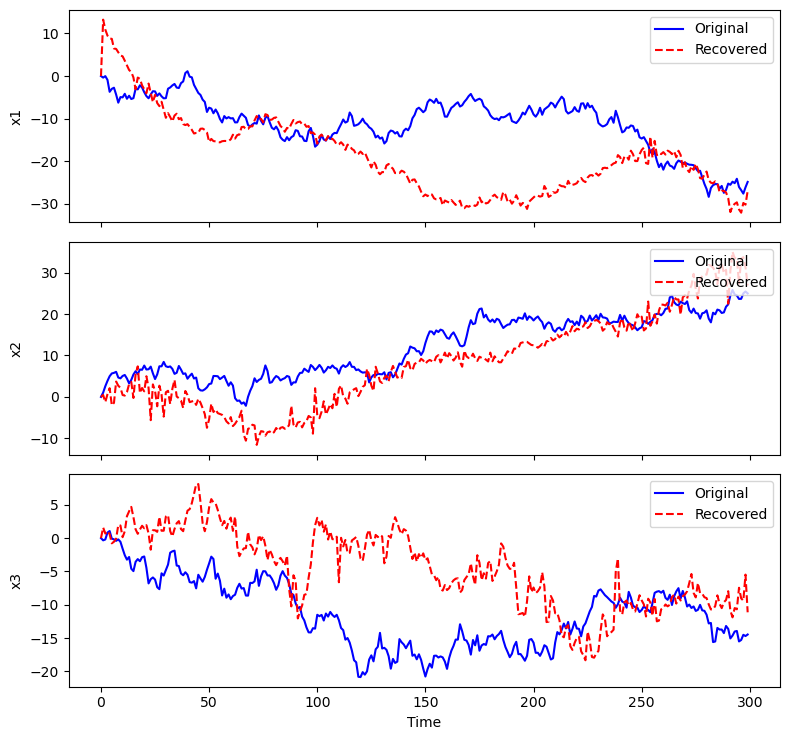

RMSE: 9.6553, MAE: 7.5535


In [24]:
import numpy as np
import torch
import signatory  
import matplotlib.pyplot as plt

def invert_signature(
    sig_target_np,
    n_steps,
    spatial_dim,
    depth,
    time_increment=1.0,
    lr=0.05,
    n_iter=2000,
    device=None
):
    """
    Invert a given signature vector into a path using gradient descent.

    Parameters:
        sig_target_np: numpy array of shape (signature_length,)
        n_steps: int, number of steps/points in the spatial path
        spatial_dim: int, spatial dimension of the path
        depth: int, signature depth
        time_increment: float, spacing for time augmentation channel
        lr: float, learning rate for optimizer
        n_iter: int, number of optimization iterations
        device: torch device (e.g., 'cpu' or 'cuda'); if None, uses CPU

    Returns:
        recovered_spatial: np.array of shape (n_steps, spatial_dim)
        losses: list of loss values during optimization
    """
    if device is None:
        device = torch.device('cpu')
    # Convert target signature vector to torch tensor, add batch dimension
    sig_target = torch.tensor(sig_target_np, dtype=torch.float32, device=device).unsqueeze(0)

    # Initialise spatial path as a random walk of length n_steps
    # shape (n_steps, spatial_dim)
    spatial_noise = np.cumsum(np.random.randn(n_steps, spatial_dim).astype(np.float32), axis=0)
    # Note: no prepended zero; the entire path of length n_steps is optimised.
    init_spatial = spatial_noise  # shape (n_steps, spatial_dim)

    # Time augmentation vector of length n_steps
    # time[i] = i * time_increment, for i=0..n_steps-1
    time = (time_increment * np.arange(n_steps, dtype=np.float32)).reshape(-1, 1)

    # Combine time and spatial into full path with time as first channel
    # shape (n_steps, spatial_dim+1)
    init_path = np.concatenate([time, init_spatial], axis=1)

    # Create torch tensor: shape (1, n_steps, spatial_dim+1)
    y_full = torch.tensor(init_path, dtype=torch.float32, device=device).unsqueeze(0)

    # Only optimise spatial part: extract and require gradients
    # y_full[..., :1] is time channel (fixed), y_full[..., 1:] is spatial
    y_spatial = y_full[:, :, 1:].clone().detach().requires_grad_(True)  # (1, n_steps, spatial_dim)

    optimizer = torch.optim.Adam([y_spatial], lr=lr)
    losses = []

    for iter_idx in range(n_iter):
        optimizer.zero_grad()

        # Rebuild full path including fixed time channel
        y_time = y_full[:, :, :1]  # shape (1, n_steps, 1), constant
        y_candidate = torch.cat([y_time, y_spatial], dim=2)  # (1, n_steps, spatial_dim+1)

        # Compute signature at specified depth
        # signatory.signature expects shape (batch, length, channels)
        sig_y = signatory.signature(y_candidate, depth)

        # Loss = L2 norm between candidate signature and target signature
        loss = torch.norm(sig_y - sig_target)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if iter_idx % 200 == 0 or iter_idx == n_iter - 1:
            print(f"Iter {iter_idx}: Loss = {loss.item():.6f}")

    # Return recovered spatial path as numpy array, shape (n_steps, spatial_dim)
    recovered_spatial = y_spatial.squeeze(0).detach().cpu().numpy()
    return recovered_spatial, losses



# === Example usage ===

index = 320  # path index

# Get the shape from the data for that specific series
n_steps, spatial_dim = X_dict[param_val][index].shape

recovered_spatial, loss_history = invert_signature(
    reconstructed_signature,
    n_steps,
    spatial_dim,
    depth,
    time_increment=1.0,
    lr=0.01,
    n_iter=4000
)

# Assume original and recovered have shape (T, d)
original = X_np_dict[param_val][i]       # shape (T, d)
recovered = recovered_spatial            # shape (T, d)
d = original.shape[1]
assert recovered.shape[1] == d

# original: shape (n_steps, spatial_dim)
# recovered_spatial: shape (n_steps, spatial_dim)

# Compute offset to align starting points
offset = original[0] - recovered_spatial[0]  # shape (spatial_dim,)

# Shift entire recovered path
recovered_spatial += offset  # shape (n_steps, spatial_dim)

# Plot x_i vs time
T = original.shape[0]
time = np.arange(T)

fig, axs = plt.subplots(d, 1, figsize=(8, 2.5 * d), sharex=True)

for i in range(d):
    ax = axs[i] if d > 1 else axs
    ax.plot(time, original[:, i], label='Original', color='blue')
    ax.plot(time, recovered[:, i], label='Recovered', color='red', linestyle='--')
    ax.set_ylabel(f'x{i+1}')
    ax.legend(loc='upper right')

axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

# Error metrics
diff = original - recovered
rmse = np.sqrt(np.mean(diff**2))
mae = np.mean(np.abs(diff))
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")


## Signature Inversion with Stochastic Gradient Descent

Iter 0: Loss = 9372390400.000000
Iter 200: Loss = 7821038080.000000
Iter 400: Loss = 7082348544.000000
Iter 600: Loss = 6217239040.000000
Iter 800: Loss = 5335884288.000000
Iter 1000: Loss = 3864814336.000000
Iter 1200: Loss = 3541000704.000000
Iter 1400: Loss = 2604818688.000000
Iter 1600: Loss = 1974425856.000000
Iter 1800: Loss = 1055948096.000000
Iter 2000: Loss = 853543936.000000
Iter 2200: Loss = 663394176.000000
Iter 2400: Loss = 607041216.000000
Iter 2600: Loss = 603176576.000000
Iter 2800: Loss = 570638784.000000
Iter 3000: Loss = 557057472.000000
Iter 3200: Loss = 563672768.000000
Iter 3400: Loss = 536580704.000000
Iter 3600: Loss = 568012224.000000
Iter 3800: Loss = 546699712.000000
Iter 4000: Loss = 529150976.000000
Iter 4200: Loss = 531336736.000000
Iter 4400: Loss = 537804800.000000
Iter 4600: Loss = 553901760.000000
Iter 4800: Loss = 526680320.000000
Iter 4999: Loss = 550846144.000000
RMSE: 9.5468, MAE: 7.7379


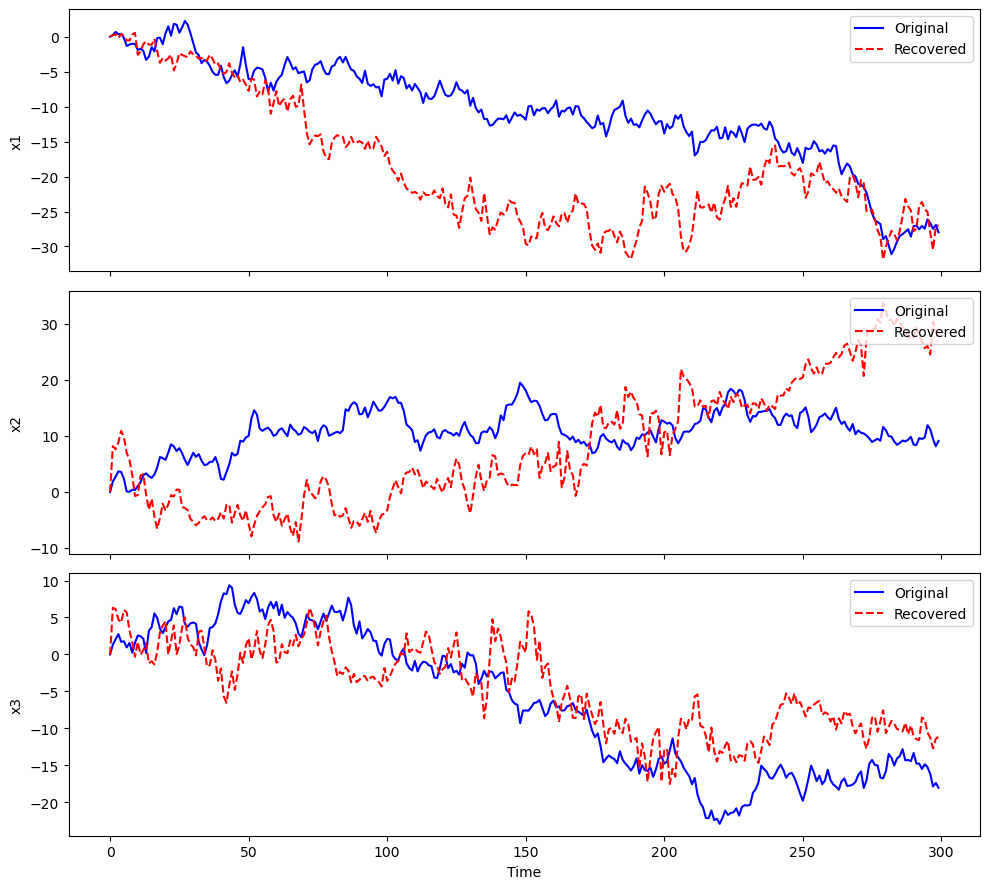

In [22]:
import numpy as np
import torch
import signatory
import matplotlib.pyplot as plt

def invert_signature_sgd(
    sig_target_np,
    n_steps,
    spatial_dim,
    depth,
    time_increment=1.0,
    lr=0.02,
    n_iter=2000,
    batch_fraction=0.8,  # fraction of remaining coeffs to randomly select
    device=None,
    fix_start_point=None  # optional: if provided as array-like of shape (spatial_dim,), will fix the first point
):
    """
    Invert a given signature vector into a path using gradient descent with random-batch loss,
    without any basepoint augmentation (path length = n_steps).

    Parameters:
        sig_target_np: numpy array of shape (signature_length,)
        n_steps: int, number of steps/points in the spatial path
        spatial_dim: int, spatial dimension of the path
        depth: int, signature depth
        time_increment: float, spacing for time augmentation channel
        lr: float, learning rate for optimizer
        n_iter: int, number of optimization iterations
        batch_fraction: float in (0,1], fraction of remaining signature indices to sample each iter
        device: torch.device or None; if None, uses CPU
        fix_start_point: optional array-like of shape (spatial_dim,). If given, the recovered path's first
                         spatial point will be fixed to this value during optimization.

    Returns:
        recovered_spatial: np.array of shape (n_steps, spatial_dim)
    """
    if device is None:
        device = torch.device('cpu')
    # Convert target signature vector to torch tensor, add batch dimension
    sig_target = torch.tensor(sig_target_np, dtype=torch.float32, device=device).unsqueeze(0)

    # Initialise spatial path as a random walk of length n_steps
    spatial_noise = np.cumsum(np.random.randn(n_steps, spatial_dim).astype(np.float32), axis=0)
    init_spatial = spatial_noise  # shape (n_steps, spatial_dim)

    # Time augmentation vector of length n_steps
    time = (time_increment * np.arange(n_steps, dtype=np.float32)).reshape(-1, 1)  # shape (n_steps,1)

    # Combine time and spatial into full path: shape (n_steps, spatial_dim+1)
    init_path = np.concatenate([time, init_spatial], axis=1)

    # Create torch tensor: shape (1, n_steps, spatial_dim+1)
    y_full = torch.tensor(init_path, dtype=torch.float32, device=device).unsqueeze(0)

    # Only optimise spatial part: extract and require gradients
    # y_full[..., :1] is time channel (fixed), y_full[..., 1:] is spatial
    y_spatial = y_full[:, :, 1:].clone().detach().requires_grad_(True)  # (1, n_steps, spatial_dim)

    # If fix_start_point is provided, prepare tensor
    if fix_start_point is not None:
        fp = torch.tensor(fix_start_point, dtype=torch.float32, device=device).view(1, 1, spatial_dim)

    optimizer = torch.optim.Adam([y_spatial], lr=lr)

    sig_len = sig_target_np.shape[0]

    # Determine first-level signature indices (one for each channel: time + spatial channels)
    # signatory orders signature coefficients lexicographically by multi-index; the first-level terms correspond to integrals
    # along each single channel. For channel count C = spatial_dim+1, these are indices 0..C-1.
    C = spatial_dim + 1
    fixed_indices = np.arange(C, dtype=int)  # indices 0 to C-1
    remaining_indices = np.arange(C, sig_len, dtype=int)

    batch_size = max(1, int(batch_fraction * len(remaining_indices)))

    for iter_idx in range(n_iter):
        optimizer.zero_grad()

        # If fixing start point, enforce it here
        if fix_start_point is not None:
            with torch.no_grad():
                y_spatial[:, 0:1, :] = fp  # fix first spatial point

        # Rebuild full path including fixed time channel
        y_time = y_full[:, :, :1]  # shape (1, n_steps, 1)
        y_candidate = torch.cat([y_time, y_spatial], dim=2)  # (1, n_steps, spatial_dim+1)

        # Compute signature at specified depth
        sig_y = signatory.signature(y_candidate, depth)  # shape (1, sig_len)

        # Randomly select a batch from the remaining indices
        selected_remaining = np.random.choice(remaining_indices, size=batch_size, replace=False)
        batch_indices = np.concatenate([fixed_indices, selected_remaining])
        batch_indices = torch.tensor(batch_indices, dtype=torch.long, device=device)

        # Compute loss on the selected coefficients
        loss = torch.norm(sig_y[:, batch_indices] - sig_target[:, batch_indices])
        loss.backward()
        optimizer.step()

        if iter_idx % 200 == 0 or iter_idx == n_iter - 1:
            print(f"Iter {iter_idx}: Loss = {loss.item():.6f}")

    # Return recovered spatial path (without time channel), shape (n_steps, spatial_dim)
    recovered_spatial = y_spatial.squeeze(0).detach().cpu().numpy()
    return recovered_spatial


# === Example usage ===

index = 320  # path index

# Get the shape from the data for that specific series
n_steps, spatial_dim = X_dict[param_val][index].shape

recovered_spatial = invert_signature_sgd(
    sig_target_np=reconstructed_signature,
    n_steps=n_steps,
    spatial_dim=spatial_dim,
    depth=depth,
    lr=0.01,
    n_iter=5000,
    batch_fraction=0.9
)


# === Plotting original vs recovered ===

original = X_np_dict[param_val][index]  # shape (T, d)

# Compute offset to align starting points
offset = original[0] - recovered_spatial[0]  # shape (spatial_dim,)

# Shift entire recovered path
recovered_spatial += offset  # shape (n_steps, spatial_dim)
d = original.shape[1]

assert recovered_spatial.shape[1] == d

diff = original - recovered_spatial
rmse = np.sqrt(np.mean(diff**2))
mae = np.mean(np.abs(diff))
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

T = original.shape[0]
time = np.arange(T)

fig, axs = plt.subplots(d, 1, figsize=(10, 3 * d), sharex=True)

for i in range(d):
    ax = axs[i] if d > 1 else axs
    ax.plot(time, original[:, i], label='Original', color='blue')
    ax.plot(time, recovered_spatial[:, i], label='Recovered', color='red', linestyle='--')
    ax.set_ylabel(f'x{i+1}')
    ax.legend(loc='upper right')

axs[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()



## Compression ratio

In [290]:
compression_ratio = (num_samples * d * len_x) / ((num_pcs + 1) * reconstructed_signature.shape[0] + num_pcs * num_samples)
print("Compression ratio is:", compression_ratio)


Compression ratio is: 12.450888163355653


In [292]:
reconstructed_signature.shape[0] 

1364

## Logsignature Inversion with Gradient Descent (differentiability issues)

## Compression Ratio for Log-Signature

## Sparse Signature Inversion with Gradient Descent
## Here, we only look at time-augmented signature coordinates of the form (1, ..., 1, k)

In [ ]:
import numpy as np
import torch
import signatory
import matplotlib.pyplot as plt


def compute_selected_positions(spatial_dim: int, depth: int):
    """
    Return sorted indices in the flattened signature vector for multi‐indices (1,...,1,k), k > 1.
    """
    channels = spatial_dim + 1  # includes time
    selected = []
    for L in range(1, depth + 1):
        base = sum(channels ** l for l in range(1, L))
        for k in range(2, channels + 1):
            pos = base + (k - 1)
            selected.append(pos)
    return sorted(selected)


def invert_sparse_signature(
    sig_target_np: np.ndarray,
    n_steps: int,
    spatial_dim: int,
    depth: int,
    selected_positions: list,
    time_increment: float = 1.0,
    lr: float = 0.1,
    n_iter: int = 2000
):
    """
    Invert a signature by matching coefficients at `selected_positions`.
    No basepoint augmentation. Start point not constrained during training.
    After training, the recovered path is offset to match the original start.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Convert target signature to tensor
    sig_target = torch.tensor(sig_target_np, dtype=torch.float32, device=device)

    # Initialise spatial path (random walk)
    spatial_path = np.cumsum(
        np.random.randn(n_steps, spatial_dim).astype(np.float32),
        axis=0
    )
    time_chan = torch.arange(n_steps, dtype=torch.float32, device=device).unsqueeze(1) * time_increment

    # Combine into full path (n_steps, spatial_dim + 1)
    y_full_init = torch.cat([time_chan, torch.tensor(spatial_path, device=device)], dim=1).unsqueeze(0)

    # Split time and spatial parts
    y_time_fixed = y_full_init[:, :, :1]  # (1, n_steps, 1)
    y_spatial = y_full_init[:, :, 1:].clone().detach().requires_grad_(True)  # (1, n_steps, d)

    optimizer = torch.optim.Adam([y_spatial], lr=lr)
    batch_idxs = torch.tensor(selected_positions, dtype=torch.long, device=device)
    losses = []

    for it in range(1, n_iter + 1):
        optimizer.zero_grad()
        y_full = torch.cat([y_time_fixed, y_spatial], dim=2)
        sig_full = signatory.signature(y_full, depth).squeeze(0)

        pred_batch = sig_full[batch_idxs]
        targ_batch = sig_target[batch_idxs]
        loss = torch.norm(pred_batch - targ_batch)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if it % 200 == 0 or it == 1 or it == n_iter:
            print(f"Iter {it:4d}  Loss = {loss.item():.6f}")

    # Final recovery and shift to match original starting point
    recovered = y_spatial.detach().cpu().squeeze(0).numpy()
    recovered -= recovered[0]  # start at 0
    return recovered, losses

# Your original spatial path
original_start = original[0]

selected_positions = compute_selected_positions(spatial_dim, depth)

recovered_spatial, loss_history = invert_sparse_signature(
    sig_target_np       = reconstructed_signature,
    n_steps             = n_steps,
    spatial_dim         = spatial_dim,
    depth               = depth,
    selected_positions  = selected_positions,
    time_increment      = 1.0,
    lr                  = 0.005,
    n_iter              = 5000
)

# Align recovered path to original start
recovered_spatial += original_start

# Plot
T = recovered_spatial.shape[0]
time = np.arange(T)
fig, axs = plt.subplots(spatial_dim, 1, figsize=(8, 2.5*spatial_dim), sharex=True)
for i in range(spatial_dim):
    axs[i].plot(time,
                original_path[:, i],
                label='Original')
    axs[i].plot(time,
                recovered_spatial[:, i],
                '--', label='Recovered')
    axs[i].set_ylabel(f'x{i+1}')
    axs[i].legend()
axs[-1].set_xlabel('Time step')
plt.tight_layout()
plt.show()



Iter    1  Loss = 3413493248.000000
Iter  200  Loss = 2604924416.000000
Iter  400  Loss = 1881553280.000000


In [294]:
# Convert to NumPy if needed
if isinstance(original, torch.Tensor):
    original = original.detach().cpu().numpy()
if isinstance(recovered, torch.Tensor):
    recovered = recovered.detach().cpu().numpy()

# Compute overall MAE and RMSE
abs_err = np.abs(original - recovered)
sqr_err = (original - recovered) ** 2

mae = np.mean(abs_err)
rmse = np.sqrt(np.mean(sqr_err))

print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")



MAE  = 8.4225
RMSE = 11.0313


## Compression Ratio

In [286]:
compression_ratio = (num_samples * d * len_x) / ((num_pcs+1)*d*5 + num_pcs * num_samples)
print("Compression ratio is:", compression_ratio)

Compression ratio is: 29.542097488921712
